# Analysis of cortical network model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from network import NeuralNetwork
from logger import logger
from utils import pressure_to_intensity

## Stimulus parameters

In [3]:
start = 200 # ms
dur = 150  # ms
tstop = 1000  # ms
Pref = 1e6  # Maximal acoustic pressure amplitude (Pa)

# Convert pressure to intensity
Iref = pressure_to_intensity(Pref) / 1e4  # (W/cm2)
logger.info(f'Iref = {Iref:.2f} W/cm2')

 01/12/2023 10:08:53: Iref = 30.91 W/cm2


## Network model

In [4]:
# Parameters of all stimulus and temperature-dependent components
params = dict(
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=0.58e-9 / (NeuralNetwork.Acell * NeuralNetwork.UM_TO_CM**2),
    gamma=4e-6
)

# Initialize 3-nodes model, with:
# - no M-type K+ current
# - all temperature-dependent conductances
nnodes = 3
model = NeuralNetwork(
    nnodes, 
    gMbar=0,
    **params
)

 01/12/2023 10:08:53: NeuralNetwork(3): created 3 nodes
 01/12/2023 10:08:53: NeuralNetwork(3): connecting all node pairs
 01/12/2023 10:08:53: NeuralNetwork(3): setting gMbar = 0 on all nodes
 01/12/2023 10:08:53: NeuralNetwork(3): setting Q10_rates = 3 on all nodes
 01/12/2023 10:08:53: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 01/12/2023 10:08:53: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 01/12/2023 10:08:53: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 01/12/2023 10:08:53: NeuralNetwork(3): setting gamma = 4e-06 on all nodes
 01/12/2023 10:08:53: NeuralNetwork(3): initialized


## Simulations

### Set baseline drive and inspect activity with various synaptic coupling strengths

 01/12/2023 10:08:53: NeuralNetwork(3): setting pre-synaptic drive on nodes [0, 1, 2]
 01/12/2023 10:08:53: creating 7.0 ± 0.7 Hz pre-synaptic drive starting at 66.0 ms
 01/12/2023 10:08:53: creating 7.0 ± 0.7 Hz pre-synaptic drive starting at 130.5 ms
 01/12/2023 10:08:53: creating 7.0 ± 0.7 Hz pre-synaptic drive starting at 60.7 ms
 01/12/2023 10:08:53: NeuralNetwork(3): disabled currents: iM, iNaKPump


 01/12/2023 10:08:53: NeuralNetwork(3): simulating for 1000.00 ms
 01/12/2023 10:08:53: NeuralNetwork(3): extracting output results
 01/12/2023 10:08:54: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.0 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 01/12/2023 10:08:54: NeuralNetwork(3): number of elicited spikes:
    - node 0: n = 7 spikes
    - node 1: n = 7 spikes
    - node 2: n = 7 spikes
 01/12/2023 10:08:54: NeuralNetwork(3): elicited firing rate:
    - node 0: FR = 7.2 ±0.4 Hz
    - node 1: FR = 7.0 ±0.5 Hz
    - node 2: FR = 7.0 ±0.6 Hz
 01/12/2023 10:08:54: NeuralNetwork(3): plotting results


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


 01/12/2023 10:09:14: NeuralNetwork(3): plotting results
 01/12/2023 10:09:14: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2


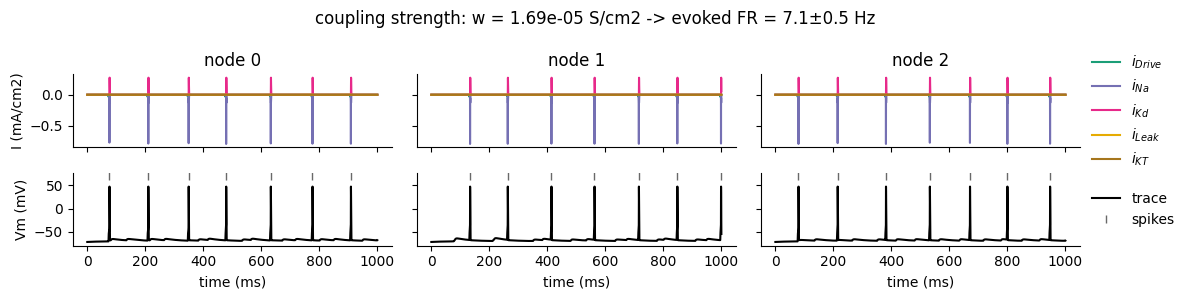

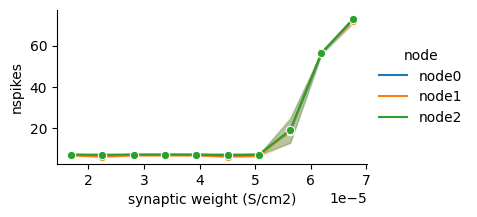

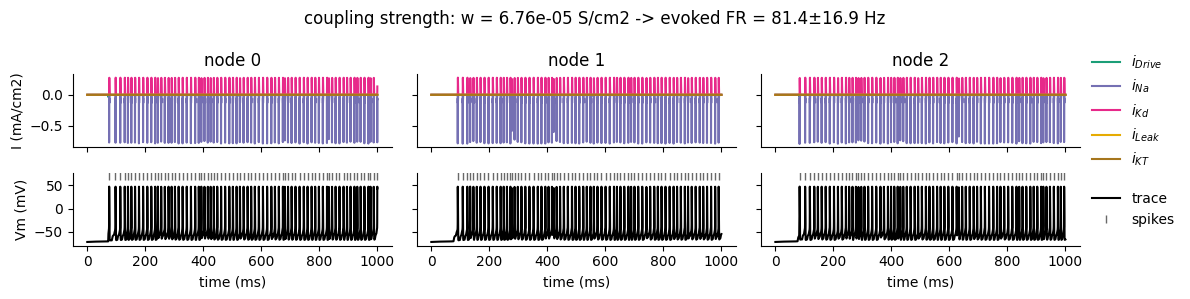

In [5]:
# Assign baseline pre-synaptic drive
model.set_presyn_drive(freq=7., noise=.1)

# Run simulation and plot results
data = model.simulate(tstop=tstop)
mu_FR, err_FR = model.compute_metric(data, 'FR').mean(axis=0)
FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
fig = model.plot_results(data, exclude=['conductances', 'T'])
fig.suptitle(f'coupling strength: w = {model.get_synaptic_weight():.2e} S/cm2 -> evoked FR = {FR_str}')

# Define vector of coupling strengths (in S/cm2)
wrange = np.linspace(1, 4, 10) * model.g_RS_RS

# Run simulation for each coupling strength, and concatenate results
data = []
nreps = 5
model.verbose = False
for w in tqdm(wrange):
    model.set_synaptic_weight(w)
    data.append(model.simulate(nreps=3))
model.verbose = True
data = pd.concat(data, keys=wrange, names=['synaptic weight (S/cm2)'])

# Plot dependency of evoked firing rate on coupling strength
fig = model.plot_sweep_results(data, 'nspikes')

# Plot results for largest coupling strength
data = data.loc[(wrange[-1], 0)]
mu_FR, err_FR = model.compute_metric(data, 'FR').mean(axis=0)
FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
fig = model.plot_results(data, exclude=['conductances', 'T'])
fig.suptitle(f'coupling strength: w = {model.get_synaptic_weight():.2e} S/cm2 -> evoked FR = {FR_str}')

# Reset synaptic weight to default value
model.set_synaptic_weight(model.g_RS_RS)

### Inspect stimulus-evoked responses with various synaptic coupling strengths

 01/12/2023 10:09:15: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2
 01/12/2023 10:09:15: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:09:15: NeuralNetwork(3): disabled currents: iM, iNaKPump


 01/12/2023 10:09:15: NeuralNetwork(3): simulating for 1000.00 ms
 01/12/2023 10:09:16: NeuralNetwork(3): extracting output results
 01/12/2023 10:09:16: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.4 °C
    - node 1: ΔT = 0.4 °C
    - node 2: ΔT = 0.4 °C
 01/12/2023 10:09:16: NeuralNetwork(3): number of elicited spikes:
    - node 0: n = 7 spikes
    - node 1: n = 6 spikes
    - node 2: n = 7 spikes
 01/12/2023 10:09:16: NeuralNetwork(3): elicited firing rate:
    - node 0: FR = 6.9 ±0.5 Hz
    - node 1: FR = 7.1 ±0.4 Hz
    - node 2: FR = 7.0 ±0.8 Hz
 01/12/2023 10:09:16: NeuralNetwork(3): plotting results
 01/12/2023 10:09:17: NeuralNetwork(3): setting all synaptic weights to 5.07e-05 S/cm2
 01/12/2023 10:09:17: NeuralNetwork(3): disabled currents: iM, iNaKPump
 01/12/2023 10:09:17: NeuralNetwork(3): simulating for 1000.00 ms
 01/12/2023 10:09:17: NeuralNetwork(3): extracting output results
 01/12/2023 10:09:18: NeuralNetwork(3): max temperature increase:
    - n

100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


 01/12/2023 10:09:54: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2


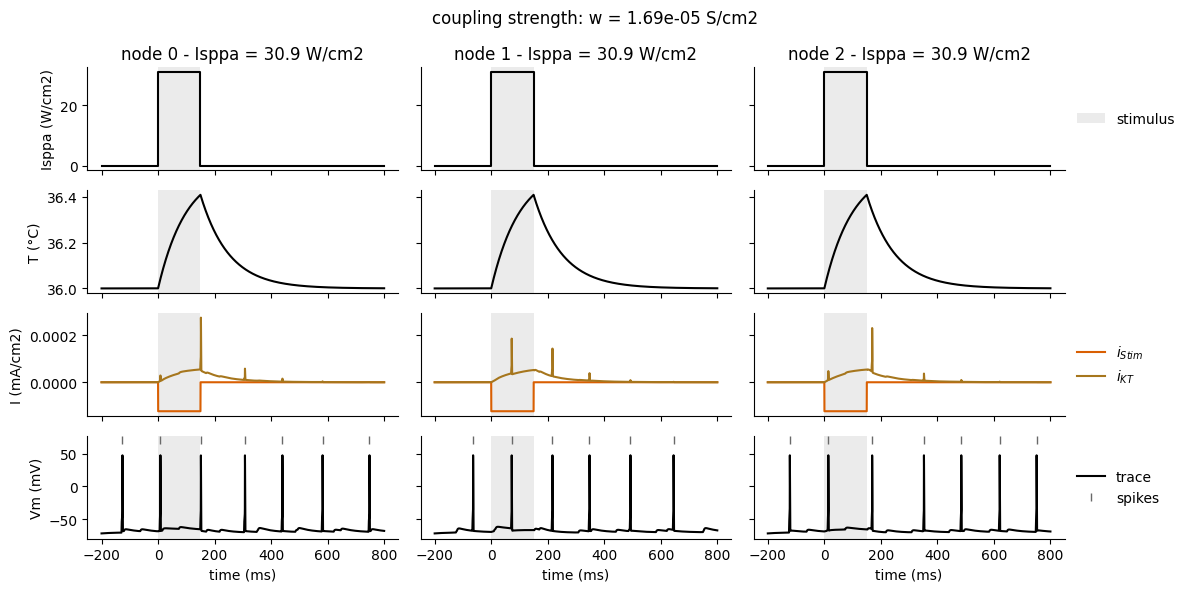

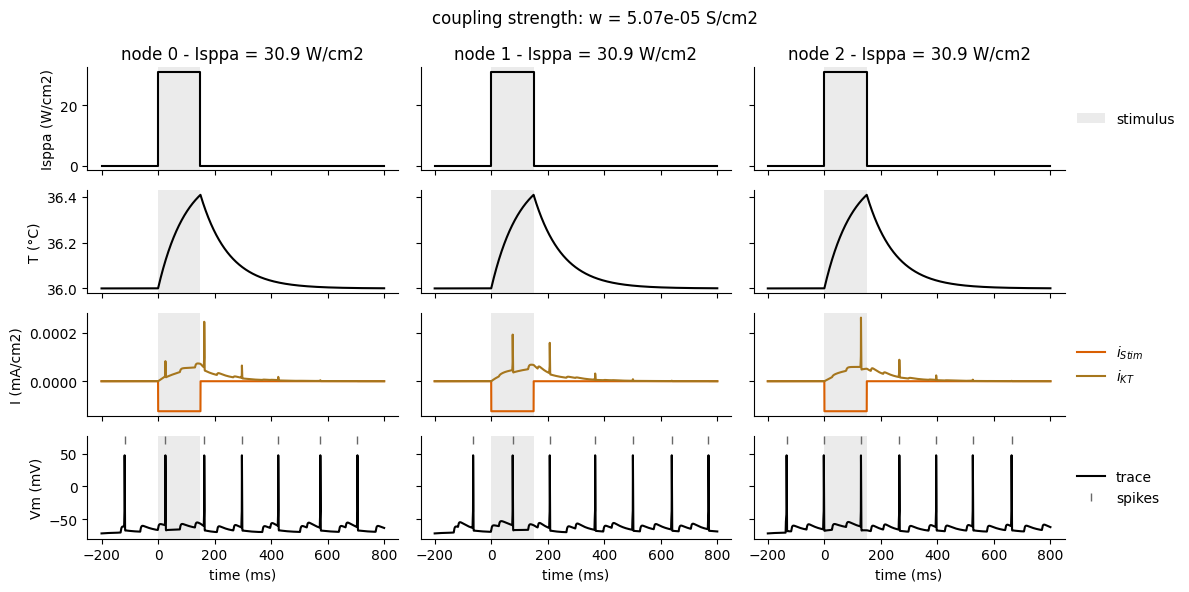

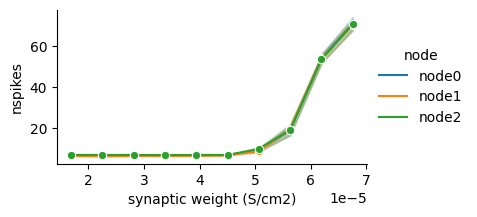

In [6]:
# # Remove baseline pre-synaptic drive
# model.remove_presyn_drive()

# Define sparse vector of coupling strengths (in S/cm2)
wrange_sparse = np.array([1, 3]) * model.g_RS_RS

# Set stimulus
model.set_stim(Iref, start=start, dur=dur)

# For each coupling strength, run simulation and plot results
for w in wrange_sparse:
    model.set_synaptic_weight(w)
    data = model.simulate(tstop=tstop)
    fig = model.plot_results(data, exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iDrive'])
    fig.suptitle(f'coupling strength: w = {model.get_synaptic_weight():.2e} S/cm2')

# Define vector of coupling strengths (in S/cm2)
wrange = np.linspace(1, 4, 10) * model.g_RS_RS

# Run simulation for each coupling strength, and concatenate results
data = []
nreps = 5
model.verbose = False
for w in tqdm(wrange):
    model.set_synaptic_weight(w)
    data.append(model.simulate(nreps=nreps))
model.verbose = True
data = pd.concat(data, keys=wrange, names=['synaptic weight (S/cm2)'])

# Plot dependency of evoked firing rate on coupling strength
fig = model.plot_sweep_results(data, 'nspikes')

# Reset synaptic weight to default value
model.set_synaptic_weight(model.g_RS_RS)

### Inpsect combined impact of stimulus sensitivity and coupling strength on spiking activity

 01/12/2023 10:11:53: NeuralNetwork(3): setting gamma = 4e-06 on all nodes


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

 01/12/2023 10:12:11: NeuralNetwork(3): setting gamma = 1e-05 on all nodes



100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

 01/12/2023 10:12:30: NeuralNetwork(3): setting gamma = 2e-05 on all nodes



100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


 01/12/2023 10:12:56: NeuralNetwork(3): setting all synaptic weights to 5.00e-05 S/cm2
 01/12/2023 10:12:56: NeuralNetwork(3): disabled currents: iM, iNaKPump
 01/12/2023 10:12:56: NeuralNetwork(3): simulating for 1000.00 ms
 01/12/2023 10:12:56: NeuralNetwork(3): extracting output results
 01/12/2023 10:12:57: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.4 °C
    - node 1: ΔT = 0.4 °C
    - node 2: ΔT = 0.4 °C
 01/12/2023 10:12:57: NeuralNetwork(3): number of elicited spikes:
    - node 0: n = 18 spikes
    - node 1: n = 18 spikes
    - node 2: n = 18 spikes
 01/12/2023 10:12:57: NeuralNetwork(3): elicited firing rate:
    - node 0: FR = 57.9 ±34.7 Hz
    - node 1: FR = 58.3 ±45.9 Hz
    - node 2: FR = 54.3 ±34.0 Hz
 01/12/2023 10:12:57: NeuralNetwork(3): plotting results
 01/12/2023 10:12:58: NeuralNetwork(3): setting gamma = 4e-06 on all nodes
 01/12/2023 10:12:58: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2


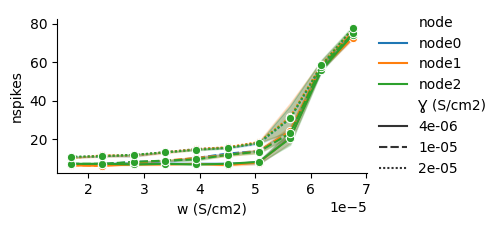

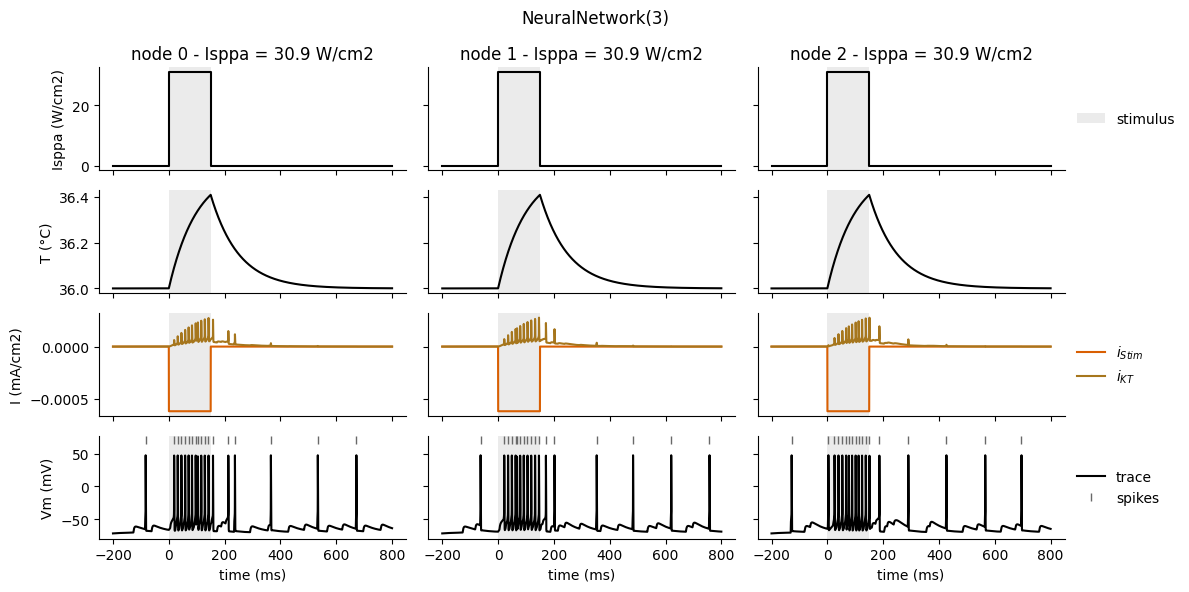

In [10]:
# Define vector of coupling strengths (in S/cm2)
wrange = np.linspace(1, 4, 10) * model.g_RS_RS

# Define vector of stimulus sensitivities (in mA/W)
Ɣrange = np.array([4e-6, 1e-5, 2e-5])

# For each stimulus sensitivity
nreps = 3
data = []
for Ɣ in Ɣrange:
    model.set_mech_param(gamma=Ɣ)

    # Run simulation for each coupling strength
    model.verbose = False
    for w in tqdm(wrange):
        model.set_synaptic_weight(w)
        data.append(model.simulate(nreps=nreps))
    model.verbose = True

# Concatenate results
data = pd.concat(
    data, 
    keys=list(itertools.product(Ɣrange, wrange)), 
    names=['Ɣ (S/cm2)', 'w (S/cm2)'])

# Plot dependency of evoked firing rate on coupling strength
model.plot_sweep_results(data, 'nspikes')

# Set parameters to enable strong evoked response without tonic firing
model.set_mech_param(gamma=2e-5)
model.set_synaptic_weight(5e-5)

# Run simulation and plot results
data = model.simulate()
fig = model.plot_results(data, exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iDrive'])

# Reset gamma and synaptic weight to their default values
model.set_mech_param(gamma=params['gamma'])
model.set_synaptic_weight(model.g_RS_RS)

### Inpspect combined impact of stimulus sensitivity and coupling strength on stimulus-evoked responses, across Isppa range

 01/12/2023 10:14:58: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:14:58: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


 01/12/2023 10:15:18: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:15:18: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


 01/12/2023 10:15:37: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 01/12/2023 10:15:37: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


 01/12/2023 10:15:56: NeuralNetwork(3): setting gamma = 1e-05 on all nodes
 01/12/2023 10:15:56: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:15:56: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


 01/12/2023 10:16:17: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:16:17: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


 01/12/2023 10:16:35: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 01/12/2023 10:16:35: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


 01/12/2023 10:16:54: NeuralNetwork(3): setting gamma = 2e-05 on all nodes
 01/12/2023 10:16:54: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:16:54: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


 01/12/2023 10:17:14: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:17:14: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


 01/12/2023 10:17:32: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 01/12/2023 10:17:32: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


 01/12/2023 10:18:03: NeuralNetwork(3): setting gamma = 4e-06 on all nodes
 01/12/2023 10:18:03: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:18:03: plotting results...


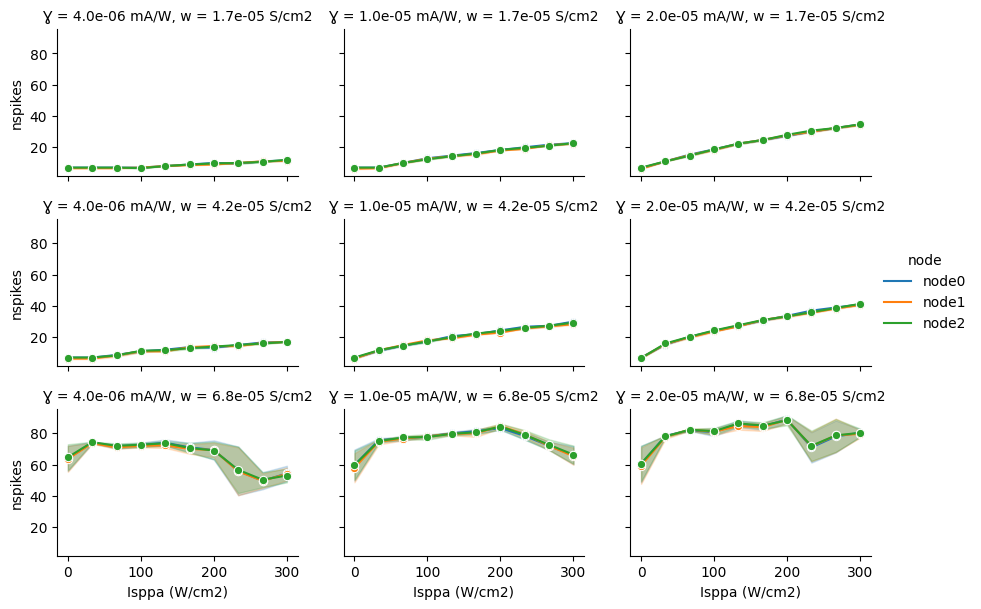

In [12]:
# Define vector of coupling strengths (in S/cm2)
wrange = np.linspace(1, 4, 3) * model.g_RS_RS

# Define vector of stimulus sensitivities (in mA/W)
Ɣrange = np.array([4e-6, 1e-5, 2e-5])

# Define vector of stimulus intensities (in W/cm2)
Isppa_range = np.linspace(0, 300, 10)

# For each stimulus sensitivity
nreps = 3
data, keys = [], []
for Ɣ in Ɣrange:
    model.set_mech_param(gamma=Ɣ)
    # For each coupling strength
    for w in wrange:
        model.set_synaptic_weight(w)
        # Run sweep over stimulus intensities, and plot results
        data.append(model.run_stim_sweep(Isppa_range, nreps=nreps))
        keys.append((Ɣ, w))

# Concatenate results
data = pd.concat(data, keys=keys, names=['Ɣ (mA/W)', 'w (S/cm2)'])

# Reset gamma and synaptic weight to their default values
model.set_mech_param(gamma=params['gamma'])
model.set_synaptic_weight(model.g_RS_RS)

# Plot results
logger.info('plotting results...')
fg = sns.FacetGrid(
    data.reset_index(),
    col='Ɣ (mA/W)',
    row='w (S/cm2)',
    aspect=1.5,
    height=2,
)
fg.set_titles('Ɣ = {col_name:.1e} mA/W, w = {row_name:.1e} S/cm2')
for iw, w in enumerate(wrange):
    for ig, Ɣ in enumerate(Ɣrange):
        gdata = data.loc[Ɣ, w]
        model.plot_sweep_results(
            gdata, 'nspikes', ax=fg.axes[iw, ig], legend=iw == 1 and ig == 2)
fig = fg.figure

### Compare evoked responses for single node vs. multi-node stimulation 

 01/12/2023 10:23:25: NeuralNetwork(3): setting gamma = 1e-05 on all nodes
 01/12/2023 10:23:25: NeuralNetwork(3): setting all synaptic weights to 2.00e-05 S/cm2
 01/12/2023 10:23:25: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 61.8 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 01/12/2023 10:23:25: NeuralNetwork(3): disabled currents: iM, iNaKPump
 01/12/2023 10:23:25: NeuralNetwork(3): simulating for 1000.00 ms
 01/12/2023 10:23:26: NeuralNetwork(3): extracting output results
 01/12/2023 10:23:26: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.8 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 01/12/2023 10:23:26: NeuralNetwork(3): number of elicited spikes:
    - node 0: n = 10 spikes
    - node 1: n = 6 spikes
    - node 2: n = 7 spikes
 01/12/2023 10:23:26: NeuralNetwork(3): elicited firing rate:
    - node 0: FR = 28.4 ±44.3 Hz
    - node 1: FR = 7.0 ±0.6 Hz
    - node 2: FR = 7.3 ±0.3 Hz
 01/12/2023 1

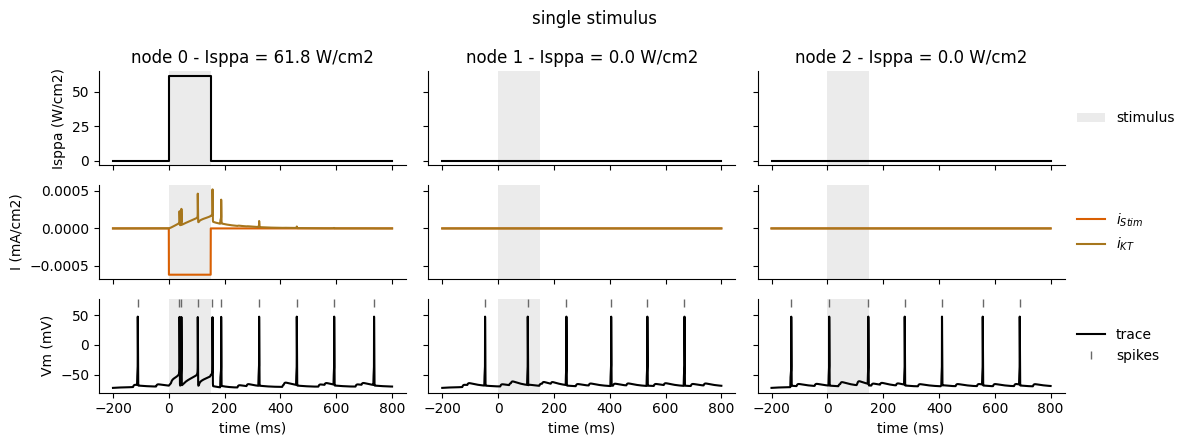

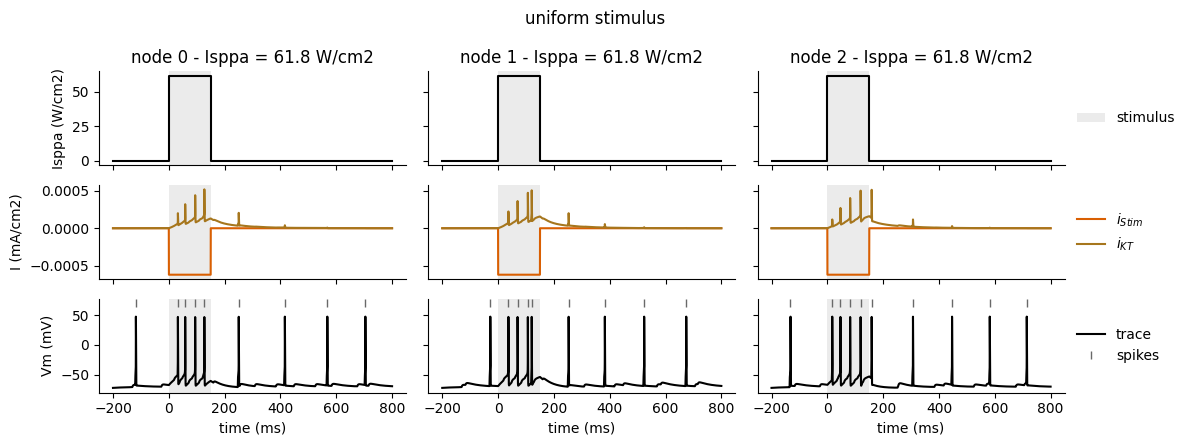

In [13]:
# Define vector of stimulus intensities per node (in W/cm2) for both 
# single and multi-node stimulation
dists = {k: model.get_stimdist_vector(kind=k) for k in ['single', 'uniform']}

# Set stimulus sensitivity and synaptic weight
model.set_mech_param(gamma=1e-5)
model.set_synaptic_weight(2e-5)

# For each stimulus distribtion, run simulation and plot results
for k, xvec in dists.items():
    model.set_stim(2 * Iref * xvec)
    data = model.simulate(tstop=tstop)
    fig = model.plot_results(data, exclude=['conductances', 'T', 'iNa', 'iKd', 'iLeak', 'iDrive'])
    fig.suptitle(f'{k} stimulus')

# Reset stimulus to default value
model.set_stim(Iref)

### Inspect Isppa dependency curves for single-node vs multi-node stimulation

 01/12/2023 10:43:03: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:43:03: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


 01/12/2023 10:43:24: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


 01/12/2023 10:43:44: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:43:44: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


 01/12/2023 10:44:04: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


 01/12/2023 10:44:24: NeuralNetwork(3): setting gamma = 1e-05 on all nodes
 01/12/2023 10:44:24: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:44:24: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


 01/12/2023 10:44:43: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


 01/12/2023 10:45:04: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:45:04: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


 01/12/2023 10:45:22: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


 01/12/2023 10:45:42: NeuralNetwork(3): setting gamma = 2e-05 on all nodes
 01/12/2023 10:45:42: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:45:42: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


 01/12/2023 10:46:01: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


 01/12/2023 10:46:20: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:46:20: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


 01/12/2023 10:46:39: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


 01/12/2023 10:47:14: NeuralNetwork(3): setting gamma = 4e-06 on all nodes
 01/12/2023 10:47:14: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:47:14: plotting results...
 01/12/2023 10:49:12: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


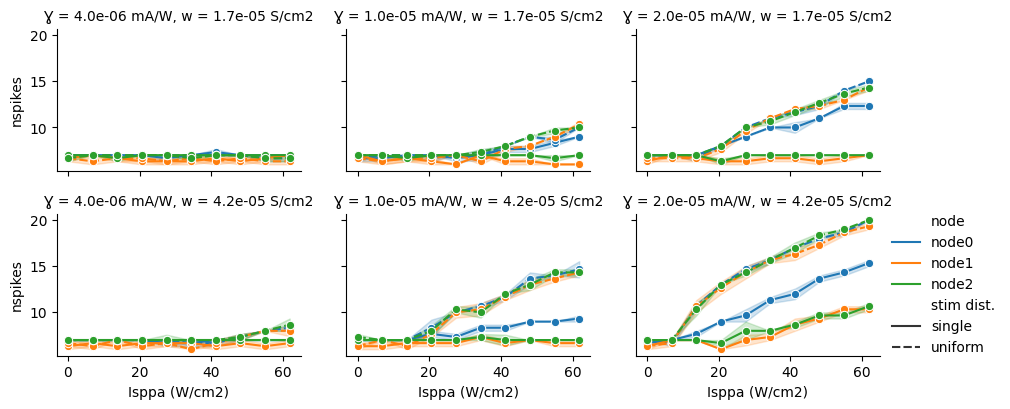

In [20]:
# Sweep parameters
Isppa_range = np.linspace(0, 2 * Iref, 10)

# Define vector of coupling strengths (in S/cm2)
wrange = np.array([1, 2.5]) * model.g_RS_RS

# For each stimulus sensitivity
nreps = 3
data, keys = [], []
for Ɣ in Ɣrange:
    model.set_mech_param(gamma=Ɣ)
    # For each coupling strength
    for w in wrange:
        model.set_synaptic_weight(w)
        # For each stimulus distribution
        for k, xvec in dists.items():
            # Run sweep over stimulus intensities, and append results to list
            data.append(model.run_stim_sweep(Isppa_range, stimdist=xvec, nreps=nreps))
            keys.append((Ɣ, w, k))

# Concatenate results
data = pd.concat(data, keys=keys, names=['Ɣ (mA/W)', 'w (S/cm2)', 'stim dist.'])

# Reset gamma and synaptic weight to their default values
model.set_mech_param(gamma=params['gamma'])
model.set_synaptic_weight(model.g_RS_RS)

# Plot results
logger.info('plotting results...')
fg = sns.FacetGrid(
    data.reset_index(),
    col='Ɣ (mA/W)',
    row='w (S/cm2)',
    aspect=1.5,
    height=2,
)
fg.set_titles('Ɣ = {col_name:.1e} mA/W, w = {row_name:.1e} S/cm2')
for iw, w in enumerate(wrange):
    for ig, Ɣ in enumerate(Ɣrange):
        gdata = data.loc[Ɣ, w]
        model.plot_sweep_results(
            gdata, 'nspikes', ax=fg.axes[iw, ig], legend=iw == 1 and ig == 2)
fig = fg.figure

# Reset stimulus amplitude to reference value
model.set_stim(Iref)